In [102]:
%matplotlib inline

import numpy as np

import joblib
from matplotlib import pyplot

import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score, classification_report, confusion_matrix
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

np.random.seed(1337)  # for reproducibility

import xgboost as xgb

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

ImportError: cannot import name 'roc_auc' from 'sklearn.metrics' (C:\Users\Suman\anaconda3\envs\sumanEnv\lib\site-packages\sklearn\metrics\__init__.py)

In [62]:
X_train = np.load('../data/train/X_train.npy') 

Y_train = np.load('../data/train/Y_train.npy')

X_test = np.load('../data/test/set1/X_test.npy')

Y_test = np.load('../data/test/set1/Y_test.npy')

X_test2 = np.load('../data/test/set2/X_test2.npy')

Y_test2 = np.load('../data/test/set2/Y_test2.npy')

In [63]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_test2 = scaler.fit_transform(X_test2)

In [64]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


print(X_test2.shape)
print(Y_test2.shape)

(28368, 42)
(28368,)
(12168, 42)
(12168,)
(7040, 42)
(7040,)


In [65]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
Y_predict = xgb_clf.predict(X_test)

In [9]:
accuracy_score(Y_test, Y_predict)

0.907215647600263

In [10]:
print(classification_report(Y_test, Y_predict, digits=6))

              precision    recall  f1-score   support

           0   0.856419  1.000000  0.922657      1521
           1   0.989583  0.999343  0.994439      1521
           2   0.981070  0.988166  0.984605      1521
           3   0.982699  0.560158  0.713568      1521
           4   0.998674  0.990138  0.994388      1521
           5   0.712244  0.982906  0.825967      1521
           6   0.844195  0.740960  0.789216      1521
           7   1.000000  0.996055  0.998024      1521

    accuracy                       0.907216     12168
   macro avg   0.920611  0.907216  0.902858     12168
weighted avg   0.920611  0.907216  0.902858     12168



In [13]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'seed': 0
    }

In [33]:
def objective(space):
    clf=xgb.XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), 
                          gamma = space['gamma'],reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                          colsample_bytree=int(space['colsample_bytree']))
    
    
    cv_results = cross_val_score(clf, X_train, Y_train, scoring='accuracy', cv = 5, verbose=5)
    
    # Extract the best score
    best_score = cv_results.max()
    
    # Loss must be minimized
    loss = 1 - best_score
    


  
    return {'loss': loss, 'status': STATUS_OK }

In [34]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

[CV]  ................................................................         
  0%|                                  | 0/100 [00:00<?, ?trial/s, best loss=?]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] .................................... , score=0.969, total=  14.0s         
[CV]  ................................................................         
  0%|                                  | 0/100 [00:14<?, ?trial/s, best loss=?]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s



[CV] .................................... , score=0.971, total=  12.7s         
[CV]  ................................................................         
  0%|                                  | 0/100 [00:26<?, ?trial/s, best loss=?]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.9s remaining:    0.0s



[CV] .................................... , score=0.964, total=  10.6s         
[CV]  ................................................................         
  0%|                                  | 0/100 [00:37<?, ?trial/s, best loss=?]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   37.5s remaining:    0.0s



  0%|                                  | 0/100 [00:45<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [35]:
xgb_clf = xgb.XGBClassifier(
 learning_rate =0.19322284808677045,
 max_depth=16,
 min_child_weight=5,
 gamma=1.8602868510188943,
 reg_alpha= 51.0,
 colsample_bytree=0.8977052885471409,
 objective='multi:softprob',
 reg_lambda= 0.19683880489336414)

xgb_clf.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8977052885471409,
              gamma=1.8602868510188943, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.19322284808677045,
              max_delta_step=0, max_depth=16, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=51.0, reg_lambda=0.19683880489336414,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [6]:
xgb_clf = xgb.XGBClassifier(
 learning_rate =0.3,
 n_estimators=810,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 reg_alpha=1e-5)




In [66]:
xgb_clf = xgb.XGBClassifier(learning_rate=0.1,
                          n_estimators=1000,
                          max_depth=5,
                          min_child_weight=1, gamma=0,
                          reg_alpha=0.01, n_jobs=-1,
                          subsample=0.5, colsample_bytree=0.5,
                          objective='multi:softprob', num_class=8)

In [67]:

eval_set = [(X_train, Y_train), (X_test, Y_test)]
xgb_clf.fit(X_train, Y_train,early_stopping_rounds=10, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)
#xgb_clf.fit(X_train, Y_train)
results = xgb_clf.evals_result()

[0]	validation_0-merror:0.02630	validation_0-mlogloss:1.72228	validation_1-merror:0.15401	validation_1-mlogloss:1.78009
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-merror:0.01251	validation_0-mlogloss:1.48486	validation_1-merror:0.11662	validation_1-mlogloss:1.58113
[2]	validation_0-merror:0.00874	validation_0-mlogloss:1.29808	validation_1-merror:0.10182	validation_1-mlogloss:1.42667
[3]	validation_0-merror:0.00779	validation_0-mlogloss:1.14504	validation_1-merror:0.10848	validation_1-mlogloss:1.30537
[4]	validation_0-merror:0.00716	validation_0-mlogloss:1.01805	validation_1-merror:0.10380	validation_1-mlogloss:1.19817
[5]	validation_0-merror:0.00634	validation_0-mlogloss:0.90878	validation_1-merror:0.10380	validation_1-mlogloss:1.10725
[6]	validation_0-merror:0.00592	validation_0-mlogloss:0.81495	validation_1-merror:0.10265	validation_1-mlogloss:1

[67]	validation_0-merror:0.00028	validation_0-mlogloss:0.00653	validation_1-merror:0.08087	validation_1-mlogloss:0.24086
[68]	validation_0-merror:0.00028	validation_0-mlogloss:0.00614	validation_1-merror:0.08144	validation_1-mlogloss:0.24170
[69]	validation_0-merror:0.00028	validation_0-mlogloss:0.00582	validation_1-merror:0.08194	validation_1-mlogloss:0.24279
[70]	validation_0-merror:0.00028	validation_0-mlogloss:0.00549	validation_1-merror:0.08202	validation_1-mlogloss:0.24345
[71]	validation_0-merror:0.00028	validation_0-mlogloss:0.00521	validation_1-merror:0.08161	validation_1-mlogloss:0.24331
[72]	validation_0-merror:0.00028	validation_0-mlogloss:0.00496	validation_1-merror:0.08235	validation_1-mlogloss:0.24428
[73]	validation_0-merror:0.00028	validation_0-mlogloss:0.00471	validation_1-merror:0.08235	validation_1-mlogloss:0.24399
[74]	validation_0-merror:0.00028	validation_0-mlogloss:0.00446	validation_1-merror:0.08259	validation_1-mlogloss:0.24341
[75]	validation_0-merror:0.00025

In [68]:
results = xgb_clf.evals_result()

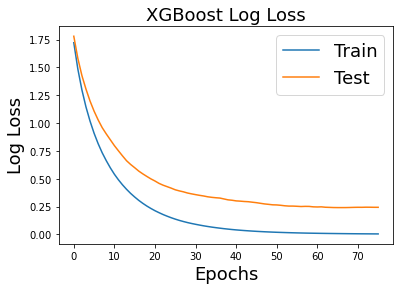

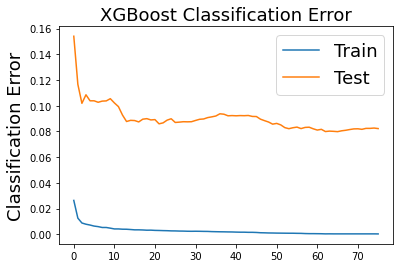

In [80]:
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend(prop={'size': 18})
pyplot.ylabel('Log Loss', fontsize=18)
pyplot.xlabel('Epochs',fontsize=18)
pyplot.title('XGBoost Log Loss',fontsize=18)
plt.savefig('train1.jpg', format='jpg')
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend(prop={'size': 18})
pyplot.ylabel('Classification Error',fontsize=18)
pyplot.title('XGBoost Classification Error',fontsize=18)
plt.savefig('train2.jpg', format='jpg')
pyplot.show()

In [70]:
Y_predict = xgb_clf.predict(X_test)
accuracy_score(Y_test, Y_predict)

0.919543063773833

In [71]:
Y_predict = xgb_clf.predict(X_test2)
accuracy_score(Y_test2, Y_predict)

0.9568181818181818

In [55]:
conf_mx=confusion_matrix(Y_test2, Y_predict)

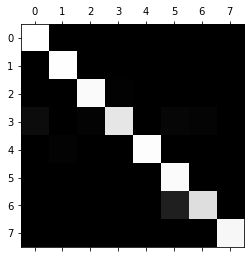

In [56]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [31]:
from sklearn.metrics import plot_confusion_matrix

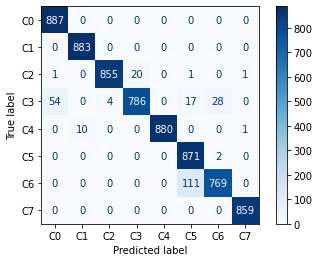

In [57]:
class_names=['C0','C1','C2','C3','C4','C5','C6','C7']

plot_confusion_matrix(xgb_clf, X_test2, Y_test2,display_labels=class_names,cmap=plt.cm.Blues)

plt.savefig('destination_path.jpg', format='jpg')

plt.show()

In [36]:
class_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [37]:
type(class_names)

numpy.ndarray

In [87]:
Y_score = xgb_clf.predict_proba(X_test2)

no_of_classes =8 

In [90]:
Y_test_bin= label_binarize(Y_test2, classes=[*range(no_of_classes)])

range(0, 8)


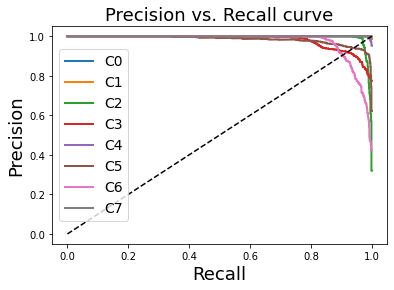

In [113]:
precision = dict()
recall = dict()
x=range(no_of_classes)
print(x)
for i in range(no_of_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test_bin[:,i],Y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='C{}'.format(i))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Recall",fontsize=18)
plt.ylabel("Precision",fontsize=18)
plt.legend(prop={'size': 14})
plt.title("Precision vs. Recall curve",fontsize=18)
plt.savefig('PR.jpg')
plt.show()

range(0, 8)


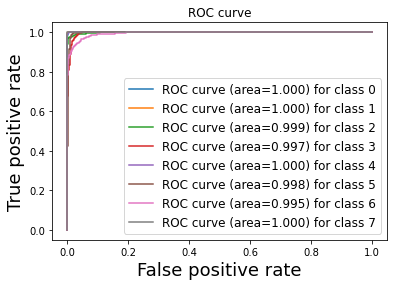

In [115]:
fpr = dict()
tpr = dict()
roc_auc={}
x=range(no_of_classes)
print(x)
for i in range(no_of_classes):
        fpr[i], tpr[i], _= roc_curve(Y_test_bin[:, i],Y_score[:,i])
        roc_auc[i]= auc(fpr[i],tpr[i])
for i in range(no_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i],Y_score[:, i])
    #plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))
    plt.plot(fpr[i], tpr[i], label='ROC curve (area=%0.3f) for class %i' %(roc_auc[i],i))

plt.xlabel("False positive rate",fontsize=18)
plt.ylabel("True positive rate",fontsize=18)
plt.legend(prop={'size': 12})
plt.title("ROC curve")
plt.savefig('ROC.jpg')
plt.show()